In [1]:
import numpy as np
import astropy.io.fits
import matplotlib.pyplot as plt
import scipy as sym 
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
import scipy.stats as stats
from astropy.stats import sigma_clip
c=const.c.to("km/s")
%matplotlib inline
cosmos = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885)  # define cosmology on the basis of simulation

In [2]:
path_2_data = 'halodir_036_0000.fit'
print('opening', path_2_data)
my_file=astropy.io.fits.open(path_2_data)
print(my_file[1].data.columns)
data = my_file[1].data

opening halodir_036_0000.fit
ColDefs(
    name = 'M200c'; format = 'D'
    name = 'M500c'; format = 'D'
    name = 'Macc'; format = 'D'
    name = 'Mpeak'; format = 'D'
    name = 'Mpeak_Scale'; format = 'D'
    name = 'Mvir'; format = 'D'
    name = 'Mvir_all'; format = 'D'
    name = 'Rs_Klypin'; format = 'D'
    name = 'Rvir'; format = 'D'
    name = 'Spin'; format = 'D'
    name = 'Spin_Bullock'; format = 'D'
    name = 'T_U'; format = 'D'
    name = 'Vmax_Mpeak'; format = 'D'
    name = 'Voff'; format = 'D'
    name = 'Vpeak'; format = 'D'
    name = 'Xoff'; format = 'D'
    name = 'b_to_a'; format = 'D'
    name = 'b_to_a_500c'; format = 'D'
    name = 'c_to_a'; format = 'D'
    name = 'c_to_a_500c'; format = 'D'
    name = 'id'; format = 'K'
    name = 'pid'; format = 'K'
    name = 'rs'; format = 'D'
    name = 'scale_of_last_MM'; format = 'D'
    name = 'vmax'; format = 'D'
    name = 'vrms'; format = 'D'
    name = 'vx'; format = 'D'
    name = 'vy'; format = 'D'
    name = '

In [3]:
# Clusters ra , dec  and z
z   = data.field('redshift_R') # 
ra  = data.field('RA') #* (np.pi/180) # degrees
dec = data.field('DEC') # * (np.pi/180) # degrees
"R_cl the virial radius of the cluster"
r_cl= data.field('Rvir').max()
r_cl

1742.74

In [4]:
data.field('M200c').max()

384630000000000.0

In [5]:
z.min(),z.max()

(0.7395160993798293, 0.819519198161372)

In [6]:

#Applying the mask"mask =np.where(data.RA<42.50)

# Cluster ra and dec
z_cl=0.76705

In [7]:
ra_cl=47.06397
dec_cl=1.96061

<IPython.core.display.Javascript object>


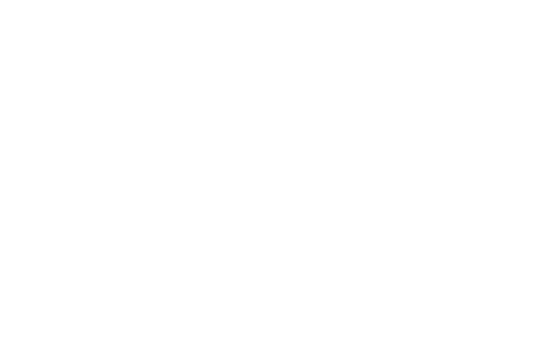

In [8]:
%matplotlib notebook
plt.plot(ra,dec,color='blue', linestyle='none', linewidth = 2, marker='.', markerfacecolor='red', markersize=5)
#plt.plot(dec[mask],ra[mask],color='blue', linestyle='none', linewidth = 2, marker='^', markerfacecolor='green', markersize=9)

In [9]:
# Measuring the actual separation of the Subhalos from the centre of Halo

D_cl=cosmos.comoving_distance(z) 
d_C = D_cl
dc_mpc = (d_C).value
dc_interpolation = interp1d(z, dc_mpc)
z_interpolation = interp1d(dc_mpc, z)
def get_x_y_z(ra_radian, dec_radian, rr):
    phi   = ( ra_radian   - 180 ) * np.pi / 180.
    theta = (dec_radian + 90 ) * np.pi / 180.
    xx = rr * np.cos( phi) * np.sin( theta )
    yy = rr * np.sin( phi) * np.sin( theta )
    zz = rr * np.cos( theta )
    return xx, yy, zz

# get 3D Cartesian positions of the sub haloes
xx, yy, zz = get_x_y_z(ra, dec, dc_interpolation(z))

#print('x mean, std',np.mean(data.field('x[mask]')-xx), np.std(data.field('x[mask]')-xx))
##print('x mean, std',np.mean(data.field('y')-yy), np.std(data.field('y')-yy))
#print('x mean, std',np.mean(data.field('z')-zz), np.std(data.field('z')-zz))

# get 3D Cartesian positions of the cluster
xx_cl, yy_cl, zz_cl = get_x_y_z(ra_cl, dec_cl, dc_interpolation(z_cl))
print('ra,dec,z=',ra_cl, dec_cl, z_cl, '\n x,y,z=',xx_cl, yy_cl, zz_cl)

# array of distances between sub haloes and the cluster : 
distances = np.sqrt((xx_cl-xx)**2 + (yy_cl-yy)**2 + (zz_cl-zz)**2)

ra,dec,z= 47.06397 1.96061 0.76705 
 x,y,z= -1889.6342137662086 -2030.9259573097575 -94.96271214997964


In [10]:
np.sort(distances)


array([1.40268813e-02, 1.61502746e-02, 2.15685746e-01, ...,
       2.81173483e+02, 2.81507473e+02, 2.81975096e+02])

In [11]:
distances.max()

281.97509644266313

In [12]:
r_cl

1742.74

In [13]:
mask= np.where(distances<r_cl/1000)
len(ra[mask])

295

<IPython.core.display.Javascript object>


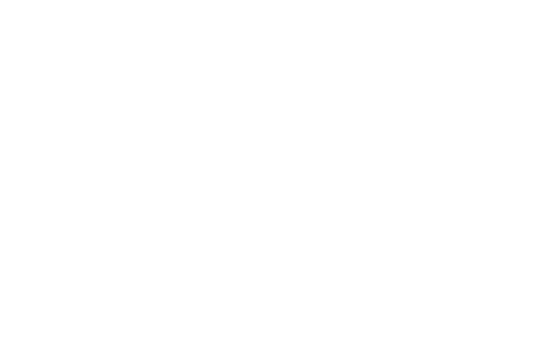

In [14]:
%matplotlib notebook
plt.plot(dec[mask],ra[mask],color='blue', linestyle='none', linewidth = 2, marker='^', markerfacecolor='green', markersize=9)

In [15]:
# From astropy inbuilt module separation
coordinates_SubHaloes = SkyCoord( ra[mask] , dec[mask], unit='deg', frame='icrs') 
coordinate_cluster    = SkyCoord( ra_cl , dec_cl, unit='deg', frame='icrs') 
Angular_separation_Astropy = coordinates_SubHaloes.separation( coordinate_cluster )
Angular_separation_Astropy_radian = (Angular_separation_Astropy).to(u.radian)

In [16]:
# Angular separation in radian
cc=Angular_separation_Astropy.radian
# Comoving distance
D = cosmos.comoving_distance(z_cl) 
print('the cluster at redshift ',z_cl,' is at dC=',D)
d_A=cosmos.angular_diameter_distance(z_cl)


the cluster at redshift  0.76705  is at dC= 2775.679308315228 Mpc


In [17]:
# Angular diameter distance
print('Angular diameter distance at the clusters redshift :' , cosmos.angular_diameter_distance(z_cl), 'per radian')
print('Angular diameter distance at the clusters redshift :' , cosmos.angular_diameter_distance(z_cl)/(180/np.pi), 'per degree')
print('Angular diameter distance at the clusters redshift :' , (cosmos.angular_diameter_distance(z_cl)/(180/np.pi)).to(u.kpc)/60, 'per arc minute    ')

Angular diameter distance at the clusters redshift : 1570.7983975072736 Mpc per radian
Angular diameter distance at the clusters redshift : 27.415603921552613 Mpc per degree
Angular diameter distance at the clusters redshift : 456.9267320258769 kpc per arc minute    


In [18]:
# The angular separation between sub haloes and the cluster converted in Mpc
r_proj =  Angular_separation_Astropy_radian * cosmos.angular_diameter_distance(z_cl)/u.radian  # where D is comoving distance
print('min, max projected distance : ',r_proj.min(), r_proj.max(), 'compared to the 3D virial radius', r_cl/1000)

min, max projected distance :  0.00012030737990501441 Mpc 0.9715790008860582 Mpc compared to the 3D virial radius 1.74274


<IPython.core.display.Javascript object>


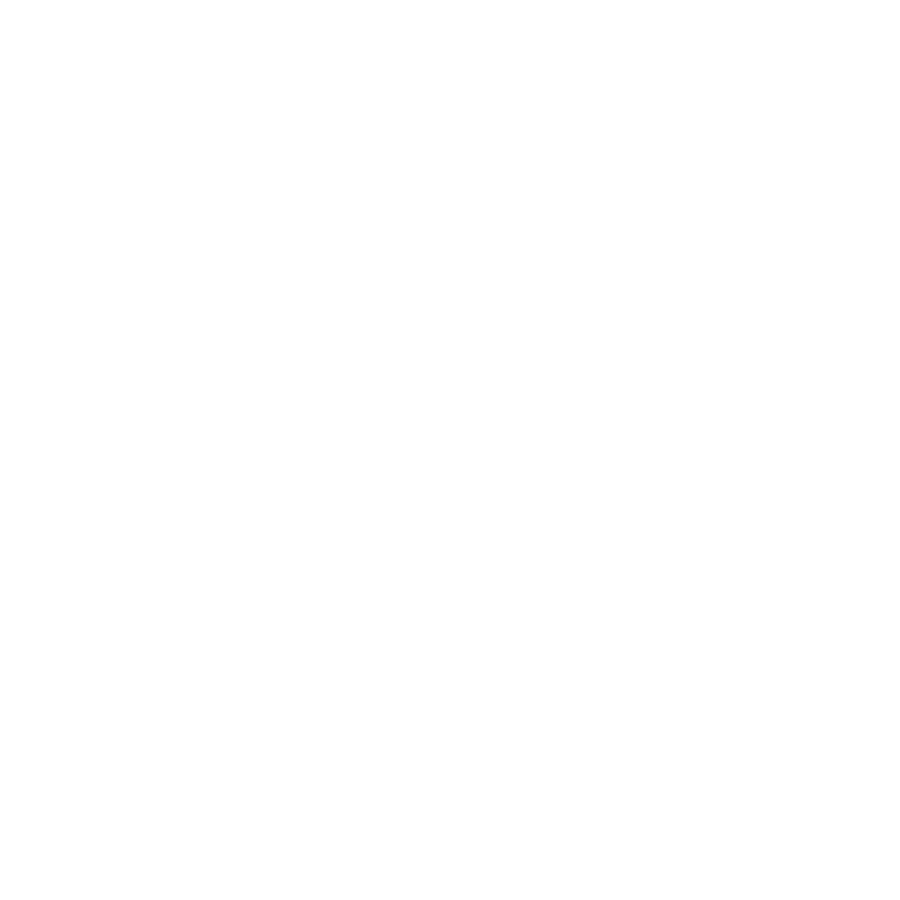

/tmp/ipykernel_33775/1182935431.py:17: RuntimeWarning: divide by zero encountered in power
  plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR/1.742, ls='')
/tmp/ipykernel_33775/1182935431.py:17: RuntimeWarning: invalid value encountered in multiply
  plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR/1.742, ls='')


In [19]:
%matplotlib notebook
# create histogram of distances in Mpc
dR = 0.08
r_bins = np.arange(0., 1.742, dR)
# Projected distance
N_2D, bins_2D = np.histogram(np.array(r_proj), bins = r_bins)
# Three D distance
N_3D, bins_3D = np.histogram(np.array(distances), bins = r_bins)

#Getting the number density profile in 2D 
n_2D = N_2D /(np.pi*( ( bins_2D[1:]**2 - bins_2D[:-1]**2) ) )

# central point of each separation 
R_2D = (bins_2D[1:] + bins_2D[:-1])/2.
plt.figure(0, (10, 10))
#plt.plot(R_2D, n_2D, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR/1.742, ls='')
plt.yscale('log')
#plt.xscale('log')
plt.title('Number density of sub haloes around the host cluster')
plt.xlabel('projected angular separation [Mpc]')
plt.ylabel(r'number density [Mpc$^{-2}$]')  
plt.show()


In [20]:
N_3D/(np.pi*( 4* ( bins_3D[1:]**3-bins_3D[:-1]**3) / 3))

array([932.54849468,   0.        ,  73.62224958,  37.80602005,
        30.57536048,  10.24778566,  11.0143523 ,   8.27705765,
        21.4872925 ,  17.20569178,  19.72156937,  14.09393191,
        16.90119873,  10.22905113,  17.73467819,  16.167623  ,
        14.26787783,  11.66954047,  12.71244297,  12.25962088,
         8.50460562])

<IPython.core.display.Javascript object>


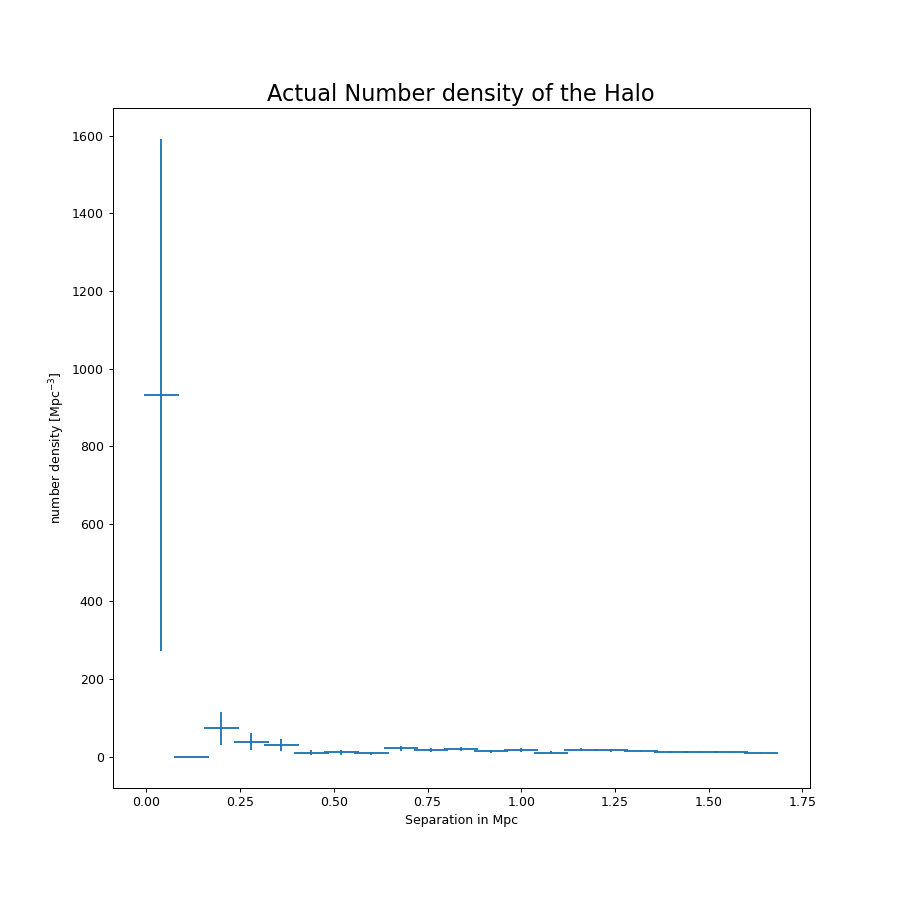

/tmp/ipykernel_33775/854608324.py:9: RuntimeWarning: divide by zero encountered in power
  plt.errorbar(r_act, number_density, xerr=dR/1.742, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
/tmp/ipykernel_33775/854608324.py:9: RuntimeWarning: invalid value encountered in multiply
  plt.errorbar(r_act, number_density, xerr=dR/1.742, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')


Text(0, 0.5, 'number density [Mpc$^{-3}$]')

In [33]:
%matplotlib notebook
number_density = N_3D/(np.pi*( 4* ( bins_3D[1:]**3-bins_3D[:-1]**3) / 3))
r_act = (bins_3D[1:] + bins_3D[:-1])/2.
#plt.xscale('log')
r_array = np.arange(0.014026881265633721, 1.7407244, 0.01)
plt.figure(0, (10, 10))

plt.title('Actual Number density of the Halo',fontsize=18)
plt.errorbar(r_act, number_density, xerr=dR/1.742, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
#plt.plot(r_act, number_density, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)

plt.xlabel('Separation in Mpc')
plt.ylabel(r'number density [Mpc$^{-3}$]')
#plt.errorbar(r_act, number_density, xerr=dR/2., ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')



In [34]:
"""
The interplation of dndR for solving the integral first of all 
Stacking the Proj and dndR

""" 
#Getting the derivative term of n wrt R_proj  ie dndR
dndR = np.array(np.gradient(n_2D,R_2D))
n_2D_no0 = N_2D
n_2D_no0[N_2D==0] = 1

dndR_up = np.array(np.gradient( n_2D + n_2D * n_2D_no0**-0.5, R_2D ))
dndR_low = np.array(np.gradient( n_2D - n_2D * n_2D_no0**-0.5, R_2D ))

def get_nu_all(dndR):
    xx = np.hstack((np.array([0]),np.array(R_2D), np.array([10.]) ))
    yy = np.hstack((np.array(dndR[0]),np.array(dndR), np.array([0.]) ))

    # getting the interpolation
    inter1 = interp1d(xx, yy, bounds_error=True)

    # De-projection of the number density profile from 
    # 2D to 3D using the Abel inversion equation

    def nu(R, r):
        """
        Latex equation
        Reference to the article it comes from
        """
        return (-1/np.pi)*(inter1(R)/((R**2 - r**2)**0.5))

    r_array = np.arange(0.014026881265633721, 1.740724477288711, 0.01)
    nu_all=[integrate.quad(nu, r_i, 1.74, args=(r_i))[0] for r_i in r_array]
    return nu_all

nu_all = get_nu_all(dndR)
nu_all_up = get_nu_all(dndR_up)
nu_all_low = get_nu_all(dndR_low)



/tmp/ipykernel_33775/793406844.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  nu_all=[integrate.quad(nu, r_i, 1.74, args=(r_i))[0] for r_i in r_array]


<IPython.core.display.Javascript object>


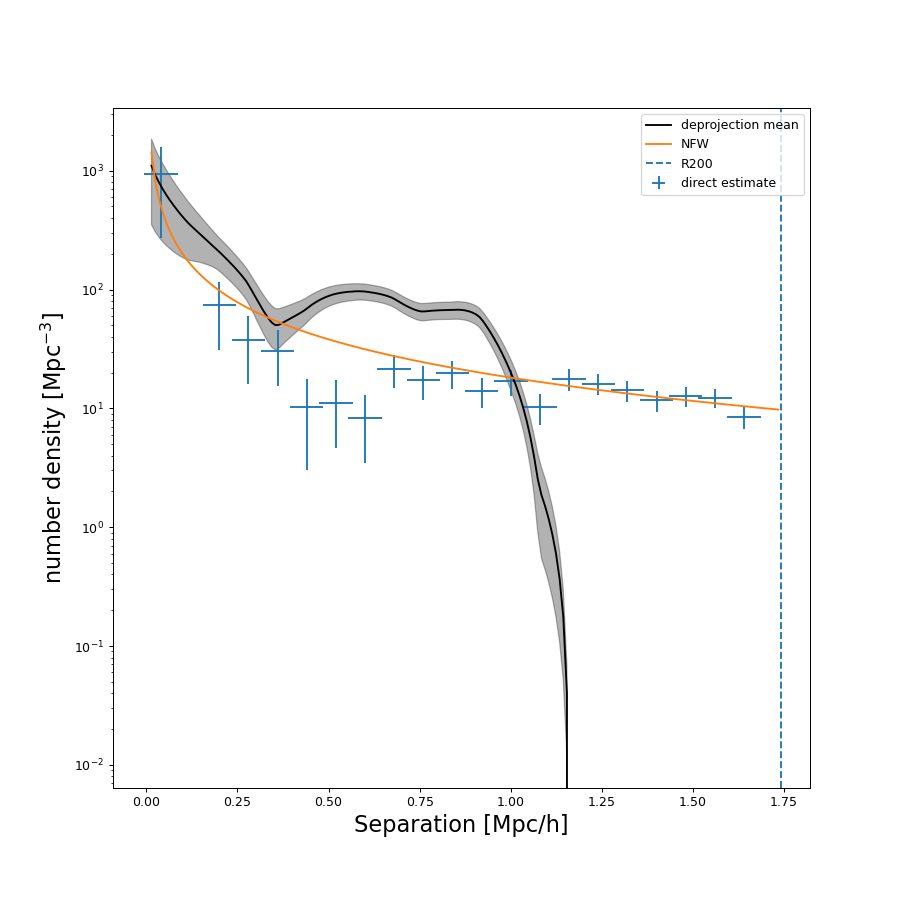

/tmp/ipykernel_33775/2755156366.py:20: RuntimeWarning: divide by zero encountered in power
  plt.errorbar(r_act, number_density, xerr=dR/1.74, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
/tmp/ipykernel_33775/2755156366.py:20: RuntimeWarning: invalid value encountered in multiply
  plt.errorbar(r_act, number_density, xerr=dR/1.74, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')


In [35]:
# plotting the de-projected number density wrt actual distance from the cluster center

%matplotlib notebook
# Nfw parameters modelling 
from colossus.halo import profile_nfw
# Parameters
Rs=20 
rhos = 1.0
# Nfw as function of actual radius of the cluster
p_nfw = profile_nfw.NFWProfile(rhos , Rs)

# Plotting the function 
plt.figure(0, (10, 10))

# Plotting  the de-projected number density
plt.plot(r_array, nu_all, label='deprojection mean', c='k')
plt.fill_between(r_array, y1=nu_all_low, y2=nu_all_up, alpha=0.3, color='k')

# Direct estimate error bars / Actual density
plt.errorbar(r_act, number_density, xerr=dR/1.74, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')

# Modelling with NFW
plt.plot(r_array,rho_nfw , label = 'NFW');
rho_nfw = p_nfw.density(r_array)
# axis
plt.xlabel('Separation [Mpc/h]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-3}$]',fontsize=18)

# r200
plt.axvline(x=1.742,linestyle='dashed',label = 'R200')

# Log scale
plt.yscale('log')
plt.legend(loc=1, numpoints=1)

In [24]:
"""
# setting  r_array
r_array = np.arange(0.014026881265633721, 1.7407244, 0.01)

# plotting the de-projected number density wrt actual distance from the cluster center
from colossus.halo import profile_nfw
#%matplotlib notebook
#Rvir = 1.1
#c = 10.0
Rs=60 #Rs = Rvir / c
rhos = 1.0
%matplotlib notebook
p_nfw = profile_nfw.NFWProfile(rhos , Rs)

# Nfw as funnction of cluster actual distance
rho_nfw = p_nfw.density(r_array)

# Figure size
plt.figure(0, (10, 10))
plt.title('Projected Number density of Halo',fontsize=18)
#plt.errorbar(r_act, number_density, xerr=dR/2., ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
plt.plot(r_array, 1*rho_nfw , label = 'NFW');
#plt.plot(r_array, nu_all, label='deprojection mean', c='k')
#plt.fill_between(r_array, y1=nu_all_low, y2=nu_all_up, alpha=0.3, color='k')
#plt.plot(R_2D, n_2D, color='black', linestyle='dashed', linewidth = 2, marker='+', markerfacecolor='green', markersize=12)
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR/2, ls='', label = 'simulation')
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)

plt.ylabel(r'number density [Mpc$^{-2}$]',fontsize=18) 
plt.axvline(x=1.90,linestyle='dashed',label = 'R200')
plt.legend(loc=1, numpoints=1)
plt.yscale('log')
#plt.xscale('log')
#plt.ylim((5, 1e3))
#plt.savefig('Nfw_simulation.png')







"""

"\n# setting  r_array\nr_array = np.arange(0.014026881265633721, 1.7407244, 0.01)\n\n# plotting the de-projected number density wrt actual distance from the cluster center\nfrom colossus.halo import profile_nfw\n#%matplotlib notebook\n#Rvir = 1.1\n#c = 10.0\nRs=60 #Rs = Rvir / c\nrhos = 1.0\n%matplotlib notebook\np_nfw = profile_nfw.NFWProfile(rhos , Rs)\n\n# Nfw as funnction of cluster actual distance\nrho_nfw = p_nfw.density(r_array)\n\n# Figure size\nplt.figure(0, (10, 10))\nplt.title('Projected Number density of Halo',fontsize=18)\n#plt.errorbar(r_act, number_density, xerr=dR/2., ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')\nplt.plot(r_array, 1*rho_nfw , label = 'NFW');\n#plt.plot(r_array, nu_all, label='deprojection mean', c='k')\n#plt.fill_between(r_array, y1=nu_all_low, y2=nu_all_up, alpha=0.3, color='k')\n#plt.plot(R_2D, n_2D, color='black', linestyle='dashed', linewidth = 2, marker='+', markerfacecolor='green', markersize=12)\nplt.errorbar(R_2D, n_2D, yerr